# DCGAN

## Imports

In [0]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import pdb
from tensorflow.examples.tutorials.mnist import input_data
from google.colab import files
import warnings

## Load data

In [2]:
IMAGE_SIZE = 28

tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])
X_train = mnist.train.images
X_train = (X_train - 0.5) / 0.5   

def leaky_relu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## Placeholder

In [0]:
x = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 1))
noise = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
Training = tf.placeholder(dtype=tf.bool)
keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')

## Generator

In [0]:
def Generator(x, keep_prob=keep_prob, Training=True, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        
        out_1 = tf.layers.conv2d_transpose(x, 256, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.dropout(out_1, keep_prob)
        out_1 = tf.layers.batch_normalization(out_1, training=Training)#batch norm
        out_1 = leaky_relu(out_1, 0.2)
        
        out_2 = tf.layers.conv2d_transpose(out_1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.dropout(out_2, keep_prob)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)
        
        out_3 = tf.layers.conv2d_transpose(out_2, 1, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_3 = tf.nn.tanh(out_3)
        return out_3

## Discriminator

In [0]:
def Discriminator(x, keep_prob=keep_prob, Training=True, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):

        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)

        out_1 = tf.layers.conv2d(x, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.dropout(out_1, keep_prob)
        out_1 = tf.layers.batch_normalization(out_1, training=Training)#batch norm
        out_1 = leaky_relu(out_1, 0.2)

        out_2 = tf.layers.conv2d(out_1, 256, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.dropout(out_2, keep_prob)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)
        
        logits = tf.layers.conv2d(out_2, 1, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W, bias_initializer=b)
        out_3  = tf.nn.sigmoid(logits)
        return out_3 ,logits

## Parameters

In [0]:
EPOCH = 20
BATCH_SIZE = 200
keep_prob_train = 0.6
BETA1 = 0.5
lr = 0.0002
label_smooth = 1

## Loss function

In [7]:
# Generate images
G_noise = Generator(noise, keep_prob, Training)
# D
D_real, D_real_logits = Discriminator(x, Training)
D_fake, D_fake_logits = Discriminator(G_noise, Training, reuse=True)
# D real loss
Dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.multiply(tf.ones_like(D_real_logits), (label_smooth))))
# D generated image loss
Dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([BATCH_SIZE, 1, 1, 1])))
# D total loss
Dis_loss = Dis_loss_real + Dis_loss_fake
# G loss
Gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([BATCH_SIZE, 1, 1, 1])))
# get all variables
tf_vars = tf.trainable_variables()
Dis_vars = [var for var in tf_vars if var.name.startswith('Discriminator')]
Gen_vars = [var for var in tf_vars if var.name.startswith('Generator')]
# optimise
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=BETA1).minimize(Dis_loss, var_list=Dis_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=BETA1).minimize(Gen_loss, var_list=Gen_vars)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d instead.


## Training

In [8]:
saver = tf.train.Saver()
num_examples = len(X_train) 
k = num_examples % BATCH_SIZE
num_examples = num_examples - k
G_loss = []
D_loss = []

D_r = []
D_f = []

    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCH):  
        start = time.time()        
        X_train = shuffle(X_train)      
        for offset in range(0, num_examples, BATCH_SIZE):
            train_d = True
            train_g = True                        
            end = offset + BATCH_SIZE
            batch = X_train[offset:end] 
            noise_ = np.random.uniform(0, 1, (BATCH_SIZE, 1, 1, 100))
                        
            #calculate loss
            d_ls = sess.run(Dis_loss,{noise: noise_, x: batch, Training: False})
            g_ls = sess.run(Gen_loss,{noise: noise_, x: batch, Training: False})
                                    
            #Gobal loss
           # d_ls_real, d_ls_fake = sess.run([Dis_loss_real, Dis_loss_fake], {noise: noise_,x: batch, Training: False})
            
            d_r = sess.run([D_real], {x: batch, Training: False})  
            d_f = sess.run([D_fake], {noise: noise_, Training: False}) 
            
            d_r = np.mean(d_r)
            d_f = np.mean(d_f)
            #break
            D_r.append(d_r)
            D_f.append(d_f)
                  
            D_loss.append(d_ls)
            G_loss.append(g_ls)
            
            if g_ls * 2 < d_ls:
                train_g = False
                pass
            if d_ls * 2 < g_ls:
                train_d = False
                pass
            
            #Update D 
            if train_d:
                sess.run(D_optim, {x: batch, noise: noise_,keep_prob: keep_prob_train,Training: True})
            
            #Update G
            if train_g:
                sess.run(G_optim, {noise: noise_, x: batch,keep_prob: keep_prob_train, Training: True})
                
        end = time.time()
        elapsed = end - start
        #break
        if ((i+1)%2 == 0)or(i==0):
            print("EPOCH {} ...".format(i+1))
            print("G_loss = {:.3f}  D_loss = {:.3f}  Time used = {:.3f}".format(g_ls, d_ls,elapsed))
            print()
    saver.save(sess, './lenet')
    print("Model saved")

EPOCH 1 ...
G_loss = 3.145  D_loss = 0.643  Time used = 99.968

EPOCH 2 ...
G_loss = 3.812  D_loss = 0.755  Time used = 97.041

EPOCH 4 ...
G_loss = 4.281  D_loss = 0.954  Time used = 97.233

EPOCH 6 ...
G_loss = 3.151  D_loss = 1.277  Time used = 93.803

EPOCH 8 ...
G_loss = 3.395  D_loss = 0.360  Time used = 95.233

EPOCH 10 ...
G_loss = 3.611  D_loss = 0.545  Time used = 91.948

EPOCH 12 ...
G_loss = 1.818  D_loss = 0.686  Time used = 94.524

EPOCH 14 ...
G_loss = 2.252  D_loss = 0.609  Time used = 94.075

EPOCH 16 ...
G_loss = 1.500  D_loss = 0.720  Time used = 94.936

EPOCH 18 ...
G_loss = 1.211  D_loss = 0.910  Time used = 93.592

EPOCH 20 ...
G_loss = 4.305  D_loss = 0.711  Time used = 91.750

Model saved


## D real and fake loss

Average D real loss
[0.59869444, 0.63691026, 0.6705274, 0.6903965, 0.6986404, 0.6321912, 0.6490014, 0.70667875, 0.6794449, 0.75576574, 0.71793115, 0.66783, 0.68794787, 0.6811988, 0.65592444, 0.70695364, 0.6221167, 0.70156085, 0.74099684, 0.72155577]
Average D fake loss
[0.11774886, 0.15681782, 0.17537437, 0.12862399, 0.09453173, 0.17630804, 0.16848461, 0.21572065, 0.1284049, 0.09077218, 0.109224536, 0.113955334, 0.14696859, 0.16208103, 0.11346606, 0.13643163, 0.161268, 0.13927227, 0.12402067, 0.07463982]


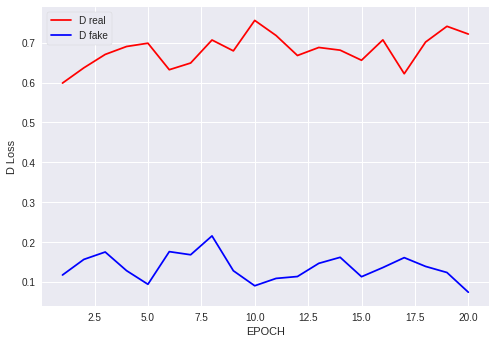

In [9]:
D_r_mean = []
D_f_mean = []

N = len(D_r)
length = N // (EPOCH)

for k in range(0,EPOCH):
  D_r_mean.append( np.mean(D_r[(k+1)*length -10 : (k+1)*length + 10] ))
  D_f_mean.append( np.mean(D_f[(k+1)*length -10 : (k+1)*length + 10] ))

print("Average D real loss")  
print(D_r_mean)
print("Average D fake loss")
print(D_f_mean)

index = np.arange(1,EPOCH+1,1)
f_d = plt.figure(1)
plt.plot(index, D_r_mean, 'r',label='D real')
plt.plot(index, D_f_mean, 'b',label='D fake')
plt.ylabel("D Loss")
plt.xlabel("EPOCH")
plt.legend(framealpha=1, frameon=True)
plt.show()


f_d.savefig('Real and fake Loss.png', dpi=600)

files.download('Real and fake Loss.png')

## Plot loss

Average D loss
[0.90146285, 0.9422904, 0.88301754, 0.872599, 0.70783794, 1.1522534, 0.9528116, 0.9062354, 0.82355994, 0.57042617, 0.7511166, 0.9525181, 0.8684064, 0.89403886, 0.9421603, 0.79412377, 1.1000445, 0.695882, 0.5961918, 0.58389765]
Average G loss
[2.801179, 2.416941, 2.0787663, 2.512952, 2.7522163, 2.4481826, 2.0887573, 1.9484046, 2.5520186, 2.7796764, 2.6277227, 3.1939147, 2.6407173, 2.3217118, 2.82863, 2.2838244, 2.810026, 2.252503, 2.3766546, 3.0593019]


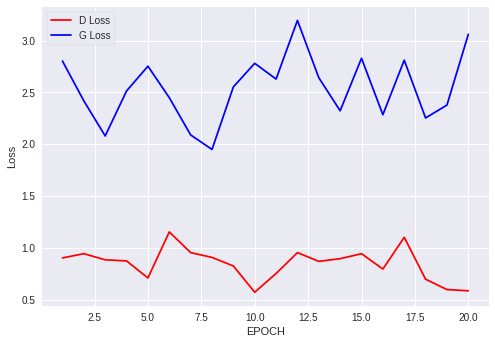

In [10]:
d_s_mean = []
g_s_mean = []

N = len(D_loss)
length = N // (EPOCH)

for k in range(0,EPOCH):
  d_s_mean.append( np.mean(D_loss[(k+1)*length -10 : (k+1)*length + 10] ))
  g_s_mean.append( np.mean(G_loss[(k+1)*length -10 : (k+1)*length + 10] ))

print("Average D loss")  
print(d_s_mean)
print("Average G loss")
print(g_s_mean)

index = np.arange(1,EPOCH+1,1)
f = plt.figure(1)
plt.plot(index, d_s_mean, 'r',label='D Loss')
plt.plot(index, g_s_mean, 'b',label='G Loss')
plt.ylabel("Loss")
plt.xlabel("EPOCH")
plt.legend(framealpha=1, frameon=True)
plt.show()

f.savefig('Loss.png', dpi=600)

files.download('Loss.png')

## Visualization

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet


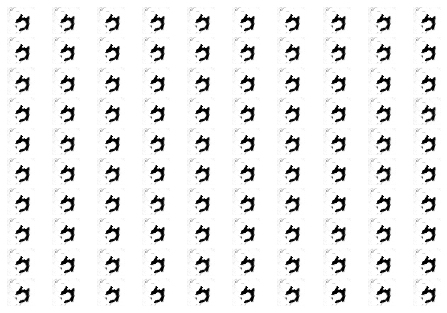

In [11]:
def plot_images(images,save = True):
    assert len(images) == 100
    img_shape = (28, 28)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(10, 10)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
                # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
    if save:    
        fig.savefig('G images_white.png', dpi=600)
        files.download('G images_white.png') 
     
n = np.random.uniform(0.0, 1.0, [100,1,1,100]).astype(np.float32) 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    images = sess.run(G_noise, {noise: n, Training: False})   
plot_images(images) 
